In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

train_data1 = np.load('data0.npy')
train_lab1 = np.load('lab0.npy')
train_data2 = np.load('data1.npy')
train_lab2 = np.load('lab1.npy')
train_data3 = np.load('data2.npy')
train_lab3 = np.load('lab2.npy')

train_data = np.concatenate([train_data1, train_data2, train_data3], axis=0)
train_labels = np.concatenate([train_lab1, train_lab2, train_lab3], axis=0)

train_data = train_data.astype(np.float32) / 255.0
train_labels = train_labels.astype(np.float32)

train_data = torch.tensor(train_data).unsqueeze(1)
train_labels = torch.tensor(train_labels)

batch_size = 64
dataset = TensorDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class DigitSumModel(nn.Module):
    def __init__(self):
        super(DigitSumModel, self).__init__()
        # Load a pre-trained ResNet and modify the input and output layers
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  
        state_dict = models.resnet50(pretrained=True).state_dict()
        state_dict['conv1.weight'] = state_dict['conv1.weight'].sum(dim=1, keepdim=True)
        self.resnet.load_state_dict(state_dict, strict=False)
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer


        # MLP to compute the sum of digits from extracted features
        self.mlp = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output single value for the sum
        )

    def forward(self, x):
        features = self.resnet(x)  # Extract features using ResNet
        output = self.mlp(features)  # Compute the sum using MLP
        return output


C:\Users\madha\AppData\Local\Temp\ipykernel_11108\1796625221.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("digit_sum_model.pth"))


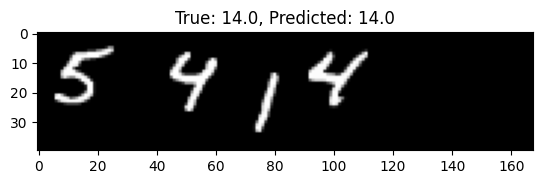

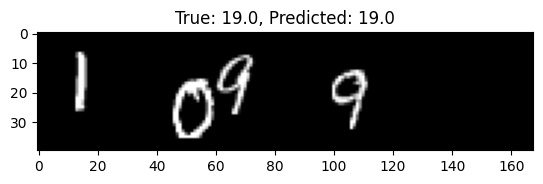

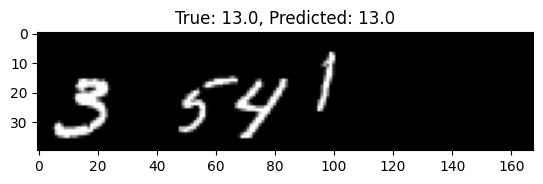

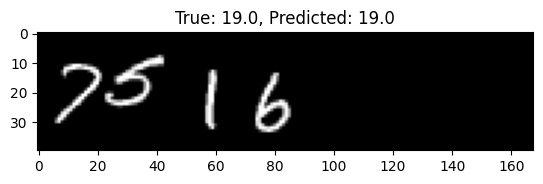

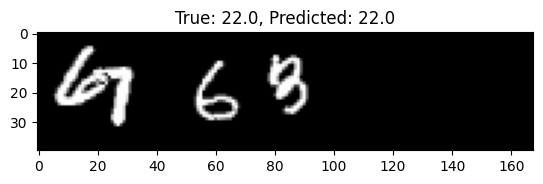

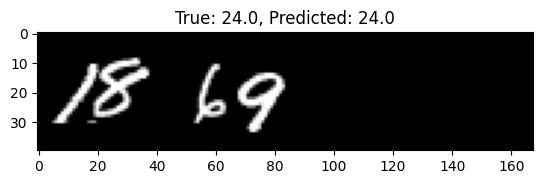

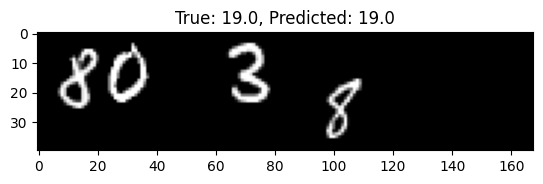

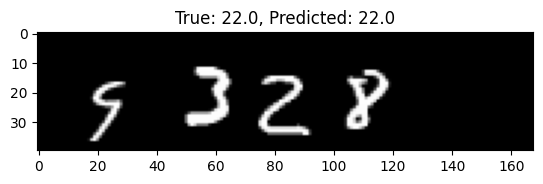

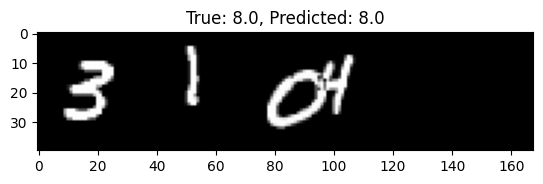

Accuracy: 98.81%


In [13]:
correct = 0
total = 0
i=0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitSumModel()
#Load Model and Find Accuracy
model.load_state_dict(torch.load("digit_sum_model.pth"))
model.eval()
model.to(device)
with torch.no_grad():
    for inputs2, labels2 in dataloader:
        i+=1
        inputs, labels = inputs2.to(device), labels2.to(device)
        outputs = model(inputs).squeeze()
        predicted = torch.round(outputs)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        if i % 50 == 0: 
            img = inputs[0].cpu().squeeze().numpy()  
            plt.imshow(img, cmap='gray')
            plt.title(f"True: {labels[0].item()}, Predicted: {predicted[0].item()}")
            plt.show()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")